# Moving through a physical experience
## Some examples of IoT application that ping a digital twin

This doc does not really teach anything new, but it will give us some exercise with the previous examples. We will need a more complicated model in future steps. 
* Adding more connections.
* Making connections using ids. 


[This is the SDK repo on Github](https://github.com/Azure/azure-sdk-for-python/tree/4559e19e2f3146a49f1eba1706bb798071f4a1f5/sdk/digitaltwins/azure-digitaltwins-core)

[Here is the doc on the query language](https://docs.microsoft.com/en-us/azure/digital-twins/concepts-query-language)


In [30]:
from azure.identity import AzureCliCredential
from azure.digitaltwins.core import DigitalTwinsClient
from IPython.display import Image

# using yaml instead of 
import yaml
import uuid

from vega_datasets import data
import numpy as np
import pandas as pd


azure_cli = AzureCliCredential()
service_client = DigitalTwinsClient(
    "home-test-twin.api.wcus.digitaltwins.azure.net", azure_cli)
service_client

In [8]:
query_expression = "SELECT * FROM digitaltwins t where IS_OF_MODEL('dtmi:billmanh:patron;1')"
query_result = service_client.query_twins(query_expression)


**Note** the query object loves to drop values. To keep from making multiple queries, save the data somewhere. 

In [9]:
values = []
for i in query_result:
    values.append(i)

In [10]:
df_customers = pd.DataFrame([[i['$dtId'],i['satisfaction']] for i in values],
                           columns=['id','satisfaction'])

In [11]:
df_customers

,id,satisfaction
0,customer-cc04f3b6-39b0-4cef-bfff-a7d668cce446,10
1,customer-3cbd5e60-957d-44ff-944f-9adb42a20a52,10
2,customer-5c454e2f-f70b-4352-b75a-958f1a49beba,7
3,customer-26196fee-5ffd-457a-86b7-192a998f3cf2,9
4,customer-e6f49d8a-711b-41c3-9db8-c7ece3dbc32c,7
...,...,...
79,customer-45e9aa03-733d-4a99-b9d5-94f1c6b04214,9
80,customer-0234cb48-1fa2-43e0-b69d-36a6ff269666,9
81,customer-75b2f757-faee-4a85-bc93-e6e9ff7cd891,6
82,customer-048f85a8-173e-4305-92b8-ead2a748b07f,8


and a `df` of the tickets

In [31]:
query_expression = f"""
SELECT * FROM digitaltwins t where IS_OF_MODEL('dtmi:billmanh:ticket;1') and t.state='open'
"""
query_result = service_client.query_twins(query_expression)
available_tickets_df = pd.DataFrame([[i['$dtId'],i['event_title'],i['state']] for i in query_result],
                                   columns = ['$dtId','event_title','state'])
available_tickets_df

,$dtId,event_title,state
0,ticket-633f4537-50a1-4735-9e70-99bf19be51e4,Smashing Pumpkins,open
1,ticket-52e25a0a-06b1-428f-b6a2-479cafc45c16,Smashing Pumpkins,open
2,ticket-0cd531c6-d81c-4c4c-84c9-9592a8f43e70,Foo Fighters,open
3,ticket-58bf00bf-d5b8-4d06-9002-f8bf1693cc56,Foo Fighters,open
4,ticket-67f3cbfb-4b35-4e10-bf6d-3fd216093c3c,Foo Fighters,open
5,ticket-3f82286d-7e0b-4df5-a491-d9e28f7c94f9,Foo Fighters,open


Let's sell a couple more of those tickets. 

In [33]:
tickets_sold = available_tickets_df.drop_duplicates(subset='event_title')['$dtId'].tolist()

tickets_sold

['ticket-633f4537-50a1-4735-9e70-99bf19be51e4',
 'ticket-0cd531c6-d81c-4c4c-84c9-9592a8f43e70']

In [34]:
customers_sold = df_customers['id'].tolist()[5:7]

customers_sold

['customer-c87adbfa-1c6e-4ea9-9f03-83e3877ef5fc',
 'customer-21e17d28-76c3-4c04-8df9-396703692a68']

The purpose is to create a simulation. So I'm just hacking something out real quick to make our model look a little fuller.

In [35]:
for c,t in enumerate(tickets_sold):
    print(t)
    tickethoder_relationship = {
            "$relationshipId": f"{t}ownedBy{customers_sold[c]}",
            "$sourceId": t,
            "$relationshipName": "ownedBy",
            "$targetId": customers_sold[c],
            "bought_online": False
        }

    service_client.upsert_relationship(
            tickethoder_relationship["$sourceId"],
            tickethoder_relationship["$relationshipId"],
            tickethoder_relationship
        )

    patch = [
        {
            "op": "replace",
            "path": "",
            "value": "sold"
        }
    ]
    service_client.update_component(t,"state", patch)

ticket-633f4537-50a1-4735-9e70-99bf19be51e4
ticket-0cd531c6-d81c-4c4c-84c9-9592a8f43e70


You should be able to load the storage explorer at this point and look at the relationships. 

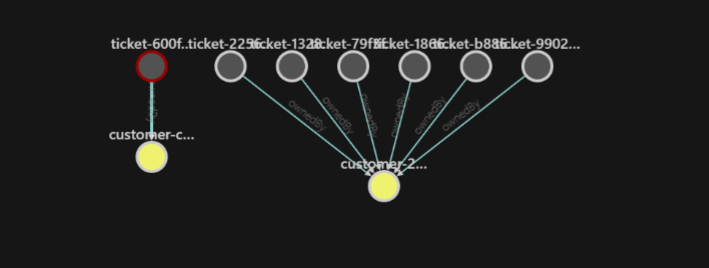

In [29]:
Image("../assets/graph_example1.png")

I'm going to add some areas. 
* People go into areas when the concert begins.
* areas have capacity

Also adding lines:
* Lines lead to other places, but one line can lead to many places (like the entrance).
* Lines have a capacity




In [87]:
# # # Delete the model that you don't want. 
# # service_client.delete_model(patron_model_id)

# # Create it if you just deleted it.
# # area_model_json = yaml.safe_load(open("models/area.json"))
# line_model_json = yaml.safe_load(open("models/Patron.json"))
# service_client.create_models([line_model_json])

Ok now that we know what tickets we want to sell, let's push them to the digital twin ecosystem. This is exactly the same as what we did with `Customers` in step one. 

In [58]:
for r in range(4):
    digital_twin_id = f'area-{r}'
    print(digital_twin_id)
    dt_json = {
        "$metadata": {
            "$model": "dtmi:billmanh:area;1"
        },
        "capacity": 3,
        "status": "open"
    }
    created_twin = service_client.upsert_digital_twin(digital_twin_id, dt_json)
    print(created_twin)

area-0
{'$dtId': 'area-0', '$etag': 'W/"7789a5c1-8ab0-473d-9c0e-6c12abe8f20f"', 'capacity': 3, 'status': 'open', '$metadata': {'$model': 'dtmi:billmanh:area;1', 'capacity': {'lastUpdateTime': '2020-11-29T23:47:16.3097488Z'}, 'status': {'lastUpdateTime': '2020-11-29T23:47:16.3097488Z'}}}
area-1
{'$dtId': 'area-1', '$etag': 'W/"78d4f941-5c4f-4e55-9a24-e1061f35a0f9"', 'capacity': 3, 'status': 'open', '$metadata': {'$model': 'dtmi:billmanh:area;1', 'capacity': {'lastUpdateTime': '2020-11-29T23:47:16.3994079Z'}, 'status': {'lastUpdateTime': '2020-11-29T23:47:16.3994079Z'}}}
area-2
{'$dtId': 'area-2', '$etag': 'W/"8d9d633f-51e1-4814-bf7f-71ffa5b647e6"', 'capacity': 3, 'status': 'open', '$metadata': {'$model': 'dtmi:billmanh:area;1', 'capacity': {'lastUpdateTime': '2020-11-29T23:47:16.4841446Z'}, 'status': {'lastUpdateTime': '2020-11-29T23:47:16.4841446Z'}}}
area-3
{'$dtId': 'area-3', '$etag': 'W/"990a5327-b8e5-4051-9ce2-9a078ec3c0aa"', 'capacity': 3, 'status': 'open', '$metadata': {'$model':

In [71]:
for r in range(4):
    digital_twin_id = f'line-{r}'
    print(digital_twin_id)
    dt_json = {
        "$metadata": {
            "$model": "dtmi:billmanh:line;1"
        }
    }
    created_twin = service_client.upsert_digital_twin(digital_twin_id, dt_json)
    print(created_twin)

line-0
{'$dtId': 'line-0', '$etag': 'W/"efd0563b-244c-41b1-8a02-7d2f5bcb11cb"', '$metadata': {'$model': 'dtmi:billmanh:line;1'}}
line-1
{'$dtId': 'line-1', '$etag': 'W/"e96e3bcb-3829-4fd0-a042-6d5f866fbd0a"', '$metadata': {'$model': 'dtmi:billmanh:line;1'}}
line-2
{'$dtId': 'line-2', '$etag': 'W/"c2f75074-3491-47b4-a703-6ade5e9993ad"', '$metadata': {'$model': 'dtmi:billmanh:line;1'}}
line-3
{'$dtId': 'line-3', '$etag': 'W/"8d749fc0-c15f-448d-b246-8f2d9212a29d"', '$metadata': {'$model': 'dtmi:billmanh:line;1'}}


Now establishing a realtionship between the lines and the areas. If a person leaves one area they have to get into the line of the next area in order to get there. 

In [77]:
def line_to_room(line,area,walking):
    tickethoder_relationship = {
                "$relationshipId": f"{line}leadsTo{area}",
                "$sourceId": line,
                "$relationshipName": "leadsTo",
                "$targetId": area,
                "walk_distance": walking
            }

    service_client.upsert_relationship(
            tickethoder_relationship["$sourceId"],
            tickethoder_relationship["$relationshipId"],
            tickethoder_relationship
        )
        
line_to_room("line-0","area-0",5)
line_to_room("line-1","area-1",5)
line_to_room("line-2","area-2",5)
line_to_room("line-3","area-3",5)

Now I'm going to add some people into different parts of the experience. This will change from user to user, but you can use this as an example of how this would work on your twin. 

In [85]:
def cust_to_area(cust,area):
    tickethoder_relationship = {
                "$relationshipId": f"{cust}locatedIn{area}",
                "$sourceId": cust,
                "$relationshipName": "locatedIn",
                "$targetId": area,
            }

    service_client.upsert_relationship(
            tickethoder_relationship["$sourceId"],
            tickethoder_relationship["$relationshipId"],
            tickethoder_relationship
        )
        
cust_to_area("customer-e6f49d8a-711b-41c3-9db8-c7ece3dbc32c","line-1")
cust_to_area("customer-21e17d28-76c3-4c04-8df9-396703692a68","line-1")
# cust_to_area("customer-25e19268-3433-4f09-afe3-94f466313368","line-0")
# cust_to_area("customer-c87adbfa-1c6e-4ea9-9f03-83e3877ef5fc","line-2")

Sell a couple more tickets

In [83]:
def ticket_to_cust(ticket,cust):
    tickethoder_relationship = {
                "$relationshipId": f"{ticket}ownedBy{cust}",
                "$sourceId": ticket,
                "$relationshipName": "ownedBy",
                "$targetId": cust,
            }

    service_client.upsert_relationship(
            tickethoder_relationship["$sourceId"],
            tickethoder_relationship["$relationshipId"],
            tickethoder_relationship
        )
        
ticket_to_cust("ticket-58bf00bf-d5b8-4d06-9002-f8bf1693cc56","customer-418cbc74-b101-4f50-8cf0-6075a2a8053c")
ticket_to_cust("ticket-67f3cbfb-4b35-4e10-bf6d-3fd216093c3c","customer-9c9b5c36-69f6-4f48-9362-4aaac4cb1be4")
